## Portfolio Optimization

In [1]:
import pandas as pd
import numpy as np
import edhc_risk_kit as erk
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The data used in this notebook is available at http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html#Research.

In [2]:
# Monthly returns of thirty different industry portfolios
ind30 = erk.get_ind_returns()
ind30.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


## Introduction to Optimization and The Efficient Frontier

### Sharpe Ratio

The Sharpe ratio was developed by Nobel laureate William F. Sharpe and is used to help investors understand the return of an investment compared to its risk. The ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. Subtracting the risk-free rate from the mean return allows an investor to better isolate the profits associated with risk-taking activities. Generally, the greater the value of the Sharpe ratio, the more attractive the risk-adjusted return.

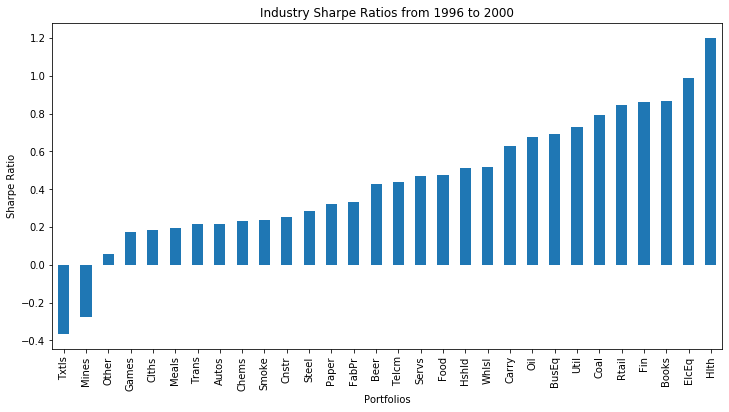

In [3]:
# Calculate Sharpe ration with a risk free rate of 3% and 12 periods per year
erk.sharpe_ratio(ind30['1996':'2000'], 0.03, 12).sort_values().plot.bar(figsize=(12,6))
plt.xlabel('Portfolios')
plt.ylabel('Sharpe Ratio')
plt.title('Industry Sharpe Ratios from 1996 to 2000');

### The Efficient Frontier

The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are sub-optimal because they have a higher level of risk for the defined rate of return.  

![title](data/efficient_frontier.png)

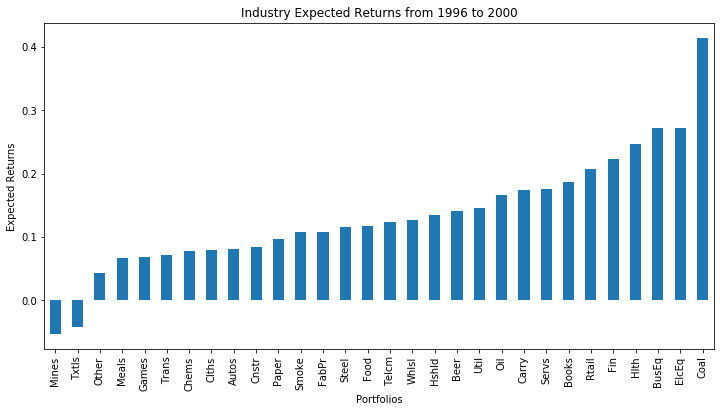

In [4]:
# Get expected returns
er = erk.annualize_rets(ind30['1996':'2000'], 12)
er.sort_values().plot.bar(figsize=(12,6))
plt.xlabel('Portfolios')
plt.ylabel('Expected Returns')
plt.title('Industry Expected Returns from 1996 to 2000');

In order to calculate the efficient frontier, we need to have an estimate of the expected returns and the covariance matrix for the set of risky securities which will used to build the optimal portfolio.  These parameters are difficult (impossible) to forecast, and the optimal portfolio calculation is extremely sensitive to these parameters.  

The function `portfolio_return` returns the matrix muliplication between the transposed vector of weights and the returns. The function `portfolio_vol` calculates the matrix multiplication between the transposed vector of weights, the covariance matrix of the returns, and the weights.

In [5]:
cov = ind30['1996': '2000'].cov()

**Calculate the return and volatility given a set of weights and returns.**

In [6]:
weights = np.repeat(1/4, 4) # Vector of weights
l = ['Food', 'Beer', 'Smoke', 'Coal'] # Names of the returns
print('Return:', erk.portfolio_return(weights, er[l]))
print('Volatility:', erk.portfolio_vol(weights, cov.loc[l, l]))

Return: 0.19511097196038385
Volatility: 0.055059195776437045


### Two Asset Frontier

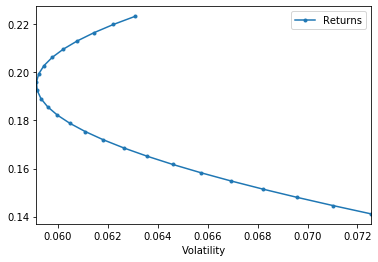

In [7]:
l = ['Fin', 'Beer']
erk.plot_ef2(25, er[l], cov.loc[l, l]);

### N Asset Frontier

The objective is to maximize the expected return, and minimize volatility. The function `minimize_vol` in the edhec_risk_kit module takes a set of target returns, the returns from a portfolio, and the covariance matrix for that portfolio and calculates a set of weights for various asset allocations such that the volatility for a particular combination is minimized and the return is maximized. Subsequently, the efficient frontier is plotted using `plot_ef` in the edhec_risk_kit module.

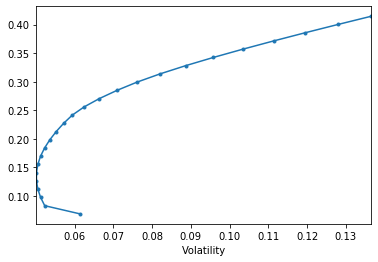

In [8]:
l = ['Smoke', 'Fin', 'Games', 'Coal']
erk.plot_ef(25, er[l], cov.loc[l, l])

## Implementing Markowitz

The capital market line (CML) represents portfolios that optimally combine risk and return. Capital asset pricing model (CAPM) depicts the trade-off between risk and return for efficient portfolios. It is a theoretical concept that represents all the portfolios that optimally combine the risk-free rate of return and the market portfolio of risky assets. Under CAPM, all investors will choose a position on the capital market line, in equilibrium, by borrowing or lending at the risk-free rate, since this maximizes return for a given level of risk. The point where the CML is tangent to the efficient frontier is called the Maximum Sharpe Ratio Portfolio.

![title](data/sharpe_portfolio.gif)

Note that the efficient frontier changes shape dramatically when a risk-free asset is introduced.

### Locating the Max Sharpe Ratio Portfolio

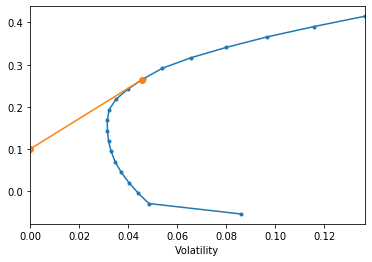

In [9]:
ax = erk.plot_ef(20, er, cov)
plt.gca().set_xlim(left=0)
rf = 0.1
w_msr = erk.msr(rf, er, cov)
r_msr = erk.portfolio_return(w_msr, er)
vol_msr = erk.portfolio_vol(w_msr, cov)
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
plt.gca().plot(cml_x, cml_y, marker='o');

Along the minimum-variance frontier, the left-most point is a portfolio with minimum variance when compared to all possible portfolios of risky assets (shown in red in the plot below). This is known as the global minimum-variance portfolio. An investor cannot hold a portfolio of risky (note: risk-free assets are excluded at this point) assets with a lower risk than the global minimum-variance (GMV) portfolio.  

The portion of the minimum-variance curve that lies above and to the right of the global minimum variance portfolio is known as the Markowitz efficient frontier as it contains all portfolios that rational, risk-averse investors would choose.

The function `plot_ef` in the `erk` module allows one to plot the GMV portfolio by setting the `show_gmv` parameter to True and the equal weight portfolio (EW, shown in yellow) by setting `show_ew` to True as well.

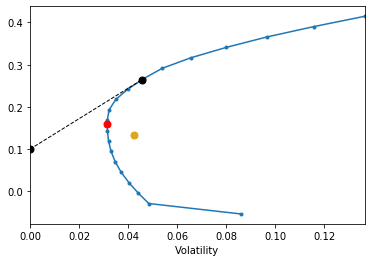

In [10]:
erk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1, show_ew=True, show_gmv=True);

Note that very small differences in the expected returns, which are likely present if we attempt to forecast them, can have a dramatic effect on the asset allocation in a portfolio.

In [11]:
# Calculate the asset allocation for returns in-sample (!)
l = ['Food', 'Steel']
print('Returns:', er[l].round(4).tolist())
print('Portfolio:', erk.msr(0.1, er[l], cov.loc[l, l]).round(4).tolist())

Returns: [0.1168, 0.1158]
Portfolio: [0.7504, 0.2496]


In [12]:
# Attempt to guess the returns
print('Portfolio:', erk.msr(0.1, np.array([0.11, 0.12]), cov.loc[l, l]).round(4).tolist())
print('Portfolio:', erk.msr(0.1, np.array([0.10, 0.13]), cov.loc[l, l]).round(4).tolist())
print('Portfolio:', erk.msr(0.1, np.array([0.13, 0.10]), cov.loc[l, l]).round(4).tolist())

Portfolio: [0.5793, 0.4207]
Portfolio: [0.0, 1.0]
Portfolio: [1.0, 0.0]


### Exercises

Use the EDHEC Hedge Fund Indices data set. Perform the following analysis based on data since 2000 (including all of 2000)

**What was the Monthly Parametric Gaussian VaR at the 1% level (as a +ve number) of the Distressed Securities strategy?**

In [13]:
hfi = erk.get_hfi_returns()
(erk.var_gaussian(hfi['2000':]['Distressed Securities'], level=1)*100).round(2)

3.14

**What was the 1% VaR for the same strategy after applying the Cornish-Fisher Adjustment?**

In [14]:
(erk.var_gaussian(hfi['2000':]['Distressed Securities'], level=1, modified=True)*100).round(2)

4.97

**What was the Monthly Historic VaR at the 1% level (as a +ve number) of the Distressed Securities strategy?**

In [15]:
(erk.var_historic(hfi['2000':]['Distressed Securities'], level=1)*100).round(2)

4.26

Using data during the 5 year period 2013-2017 (both inclusive) for the 30 industry return data, estimate the expected returns as well as the covariance matrix for the `Books`, `Steel`, `Oil`, and `Mines` industries. Assume the risk free rate over the 5 year period is 10%.

In [16]:
l = ['Books', 'Steel', 'Oil', 'Mines']

In [17]:
cov = ind30['2013':'2017'].cov()

**What is the weight of Steel in the EW Portfolio?**

In [18]:
print(0.25)

0.25


**What is the weight of the largest component of the MSR portfolio?**

In [19]:
msr_weights = erk.msr(0.1, er[l], cov.loc[l, l])
print(msr_weights.max(), l[msr_weights.argmax()])

0.786011784161686 Books


**What is the weight of the largest component of the GMV portfolio?**

In [20]:
gmv_weights = erk.gmv(cov.loc[l, l])
print(gmv_weights.max(), l[gmv_weights.argmax()])

0.47702487032166246 Books
